In [1]:
import numpy as np
import matplotlib as mpl
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

import SOM.SOM as som

# <span style="color:green"> SOM DEMO using "neighborhood differences" driving mesh adaptation </span>

In [2]:
'''
    To demonstrate/test the SOM, we'll create a some of two 2D gaussians on a plane to use as "values" of the SOM weights
'''
##### unsed to set dimension of mesh and of value array
NUMCOLS = 20 # 7  #num cols
NUMROWS = 20# 5  #num rows

#p1 =kmap(5,4,np.array([0,0]),np.array([0,3]),np.array([4,0]),np.array([4,3])) #( ylength (num rows), (xlength (num cols))
p1 =som.kmap(NUMROWS,NUMCOLS,np.array([-2, -2]),np.array([-2, 2]),np.array([2, -2]),np.array([2,2])) #( ylength (num rows), (xlength (num cols))
p1.weights.shape

weights.shape is (20, 20, 2)
xspacing is 0.21052631578947345. and yspacing is 0.2977291710259144
weights2D.shape is (20, 20, 2)


(20, 20, 2)

In [3]:
'''
    The plt arg is so we can plot the mesh on top of other plots
'''
def plotmesh(m,n, p=plt) : 
    p.scatter(m,n, color="black")

    segs1 = np.stack((m,n), axis=2)
    segs2 = segs1.transpose(1,0,2)
    p.gca().add_collection(LineCollection(segs1, colors='black'))
    p.gca().add_collection(LineCollection(segs2, colors='black'))
    p.show()  
    return p

In [4]:
'''
    For creating the 2D Gaussians
'''
# Mean vector and covariance matrix
mu2 = np.array([1.,-1])
Sigma2 = np.array([[ 1. , .8], [0.8,  1.]])

mu1 = np.array([-1.,1])
Sigma1 = np.array([[ 1. , -.8], [-.8,  1.]])


def multivariate_gaussian(x,y, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) # Note: unnormalized, with max=1


def two_Guassians(x,y, mu1, Sigma1, mu2, Sigma2):
    return multivariate_gaussian(x,y, mu1, Sigma1)+ multivariate_gaussian(x,y, mu2, Sigma2)

In [5]:
# Save the initial Guassian values over the evenly-spaced mesh before it moves
initX,initY = p1.locationMesh()
initZ = two_Guassians(initX, initY, mu1, Sigma1, mu2, Sigma2)

print(f"size of Z is {initZ.shape}")


size of Z is (20, 20)


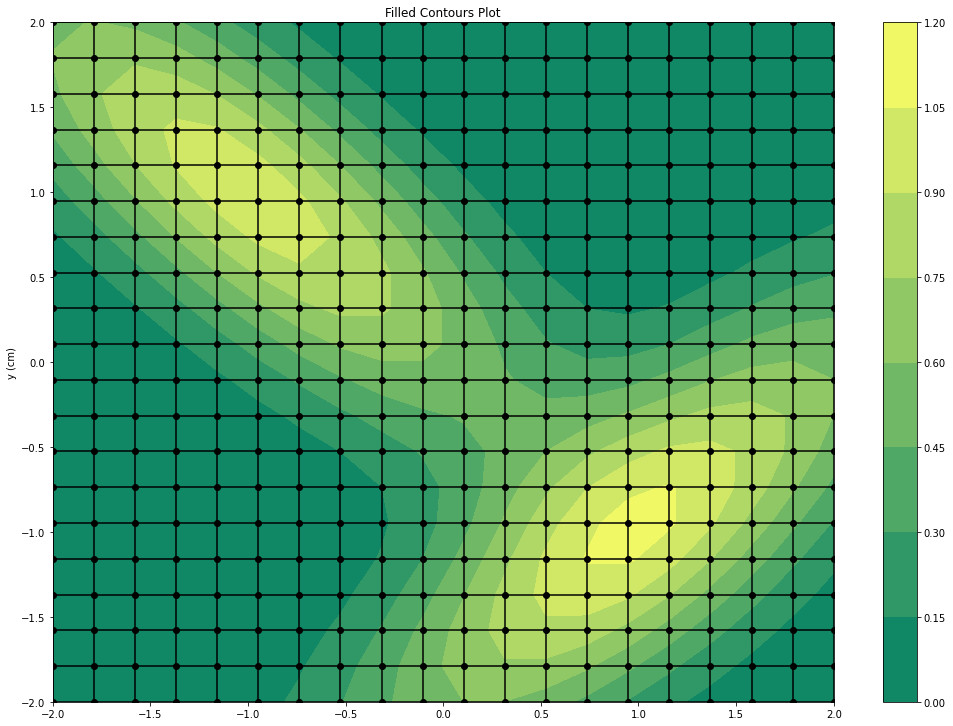

In [6]:
'''
    Plot the initial mesh weights over the function that will drive its evolution 
'''
cmap = "summer" #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(initX, initY, initZ, cmap=cmap)

fig.set_size_inches(17.5, 12.5)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')http://localhost:8889/notebooks/scratchbook/SOM.ipynb#
ax.set_ylabel('y (cm)')

plotmesh(initX,initY, plt)

plt.show()

In [7]:
'''
    HERE IS WHERE WE DO THE ITERATION
'''

# Let's make record of histograms of the spacing between mesh points since we want to see them 
#   approach a more uniform value. 

hgram=[]
hgramInterval=100
#hgramInterval=25

old_magsum=9999999999

for i in range(1001) :
#for i in range(501) :
    # get the new locations
    mX,mY = p1.locationMesh()
    # Compute the values of the functions at each node location 
    G = two_Guassians(mX,mY, mu1, Sigma1, mu2, Sigma2)
    
    weightchange, diffm =p1.weightUpdate(G, clampedges=True)
    print(f"{i}: weightchange is {weightchange}")
    
    # occaissionally save the histogram of differences between nodes
    if i%hgramInterval == 0 :
        #print(f"save histogrqam at step {i}")
        hgram.append(np.histogram(diffm[:,:], 12,(0,.2)))

    

0: weightchange is 25.63406881907602
1: weightchange is 24.69353988362527
2: weightchange is 23.83772992949329
3: weightchange is 23.05156202157613
4: weightchange is 22.32223304211716
5: weightchange is 21.64257133383658
6: weightchange is 21.007649555413636
7: weightchange is 20.409463995655145
8: weightchange is 19.84916010124302
9: weightchange is 19.322937885892905
10: weightchange is 18.825347998486464
11: weightchange is 18.355141950079826
12: weightchange is 17.907812637410323
13: weightchange is 17.482010676619524
14: weightchange is 17.07281175598213
15: weightchange is 16.680676337330915
16: weightchange is 16.30875060705494
17: weightchange is 15.954630148859106
18: weightchange is 15.616558707177942
19: weightchange is 15.293466305856652
20: weightchange is 14.984380298086535
21: weightchange is 14.688414349332024
22: weightchange is 14.404758906829066
23: weightchange is 14.13267290049689
24: weightchange is 13.871476481449141
25: weightchange is 13.62054464568536
26: wei

325: weightchange is 3.8727687269575757
326: weightchange is 3.8673074326068955
327: weightchange is 3.8618646276514945
328: weightchange is 3.856440111146079
329: weightchange is 3.8510338581538193
330: weightchange is 3.845645731907452
331: weightchange is 3.8402756005095364
332: weightchange is 3.8349233363320976
333: weightchange is 3.8295888155498616
334: weightchange is 3.8242719177708935
335: weightchange is 3.8189725257395404
336: weightchange is 3.813690525093906
337: weightchange is 3.8084258041651653
338: weightchange is 3.8031782538095906
339: weightchange is 3.7979477672667104
340: weightchange is 3.7927342400384516
341: weightchange is 3.787537569785884
342: weightchange is 3.78235765624067
343: weightchange is 3.777194401129287
344: weightchange is 3.7720477081086097
345: weightchange is 3.7669174827115857
346: weightchange is 3.761803632302405
347: weightchange is 3.7567060660407012
348: weightchange is 3.751624694854291
349: weightchange is 3.7465594314205704
350: weig

581: weightchange is 2.8675388124268464
582: weightchange is 2.8648038297839316
583: weightchange is 2.8620756516234866
584: weightchange is 2.859354248555647
585: weightchange is 2.856639591638438
586: weightchange is 2.8539316523702514
587: weightchange is 2.8512304026821624
588: weightchange is 2.848535814929824
589: weightchange is 2.8458478618850878
590: weightchange is 2.843166516727182
591: weightchange is 2.8404917530334086
592: weightchange is 2.837823544769379
593: weightchange is 2.835161866278674
594: weightchange is 2.832506692271898
595: weightchange is 2.8298579978150293
596: weightchange is 2.8272157583171236
597: weightchange is 2.8245799495171813
598: weightchange is 2.821950547470231
599: weightchange is 2.819327528532546
600: weightchange is 2.816710869345964
601: weightchange is 2.8141005468212636
602: weightchange is 2.811496538120562
603: weightchange is 2.808898820638856
604: weightchange is 2.8063073719844134
605: weightchange is 2.8037221699584136
606: weightc

830: weightchange is 2.3322586495344906
831: weightchange is 2.33068399237096
832: weightchange is 2.329111683575193
833: weightchange is 2.3275417015792867
834: weightchange is 2.325974025639647
835: weightchange is 2.3244086357896774
836: weightchange is 2.3228455127961203
837: weightchange is 2.321284638118788
838: weightchange is 2.3197259938734636
839: weightchange is 2.31816956279759
840: weightchange is 2.316612285667599
841: weightchange is 2.3150538543935495
842: weightchange is 2.3134976620086327
843: weightchange is 2.31194367523638
844: weightchange is 2.3103972572727756
845: weightchange is 2.3088583043713617
846: weightchange is 2.3073214462128053
847: weightchange is 2.3057866562700937
848: weightchange is 2.3042539094530277
849: weightchange is 2.302723182031393
850: weightchange is 2.301194451562749
851: weightchange is 2.2996631527097784
852: weightchange is 2.2981230118570792
853: weightchange is 2.29658642273699
854: weightchange is 2.2950532970983266
855: weightcha

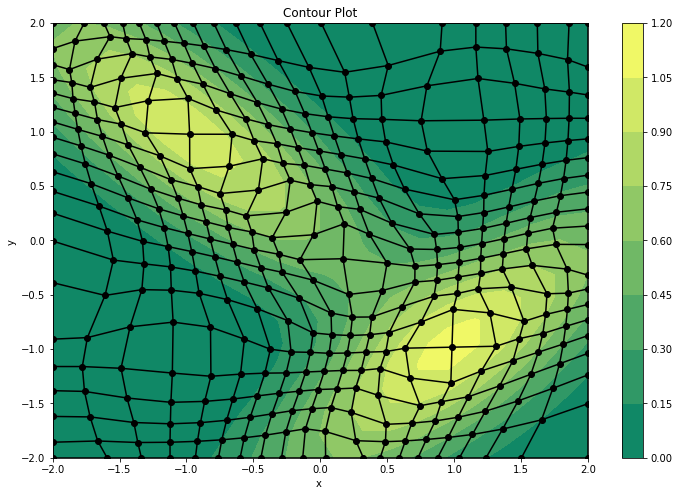

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [15]:
cmap = "summer" #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig,ax=plt.subplots(1,1)
fig.set_size_inches(12, 8)
cp = ax.contourf(initX, initY, initZ, cmap=cmap)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Contour Plot')
ax.set_xlabel('x ')
ax.set_ylabel('y ')

# get out mesh of node weights
m,n = p1.locationMesh()

##########   quiver
if False :
    A = m #np.arange(-10, 10, 1)
    B = n
    #U, V = np.meshgrid(X, Y)
    C=dv[:,:,0]
    D=dv[:,:,1]
    q=ax.quiver(A, B, C, D, linewidths=-1)
    ax.quiverkey(q, X=0.3, Y=1.1, U=100,
                 label='Quiver key, length = 10', labelpos='E')

##########
#Put the mesh on top of the values
plotmesh(m,n, plt)
#plt.show()

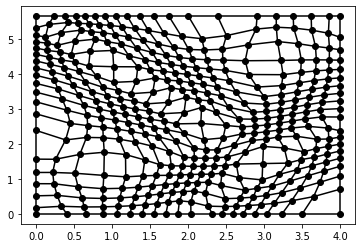

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [14]:
plotmesh(p1.weights2D[:,:,0], p1.weights2D[:,:,1],plt)

Text(0.5, 0, 'number of nodes in bin')

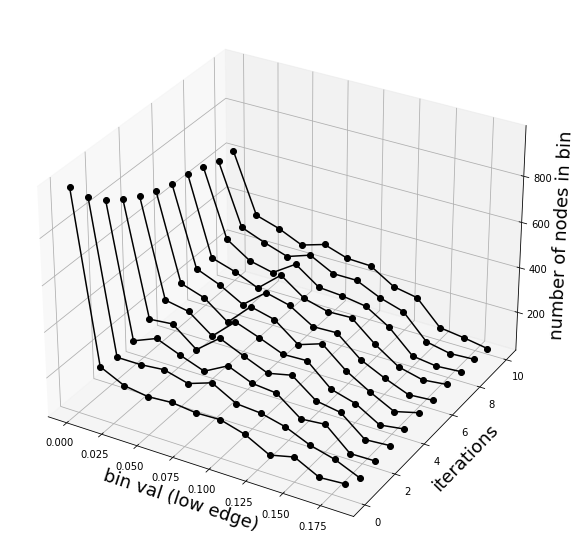

In [10]:
'''
    Plot the histograms of value differences between nodes over times
'''
#import matplotlib.pylab as pl
#from matplotlib import colors
#from mpl_toolkits.mplot3d import Axes3D


nbins=len(hgram[0][0])
nsteps=len(hgram)
y=np.zeros((nsteps, nbins))
z=np.zeros((nsteps, nbins))
x   = hgram[0][1][:nbins]  #bin center
for snum in range(0, nsteps) :
    y[snum]  = np.ones(nbins)*snum
    z[snum]   = hgram[snum][0]


fig1=plt.figure(figsize=(10,10))
#ax11=fig1.add_subplot(211,projection='3d')
ax11=fig1.add_subplot(111,projection='3d')

#ax = pl.subplot(projection='3d')
for snum in range(0, nsteps) :
    #ax11.plot(x, y[snum], z[snum], marker='o', color=colors.hsv_to_rgb([np.random.uniform(0, 1),.7,1]))
    ax11.plot(x, y[snum], z[snum], marker='o', color='#000000')


ax11.set_xlabel('bin val (low edge)', fontsize=18)
ax11.set_ylabel('iterations', fontsize=18)
ax11.set_zlabel('number of nodes in bin', fontsize=18) 

In [11]:
np.average(diffm[:,:])

0.07398820945977133

Text(0, 0.5, 'y ')

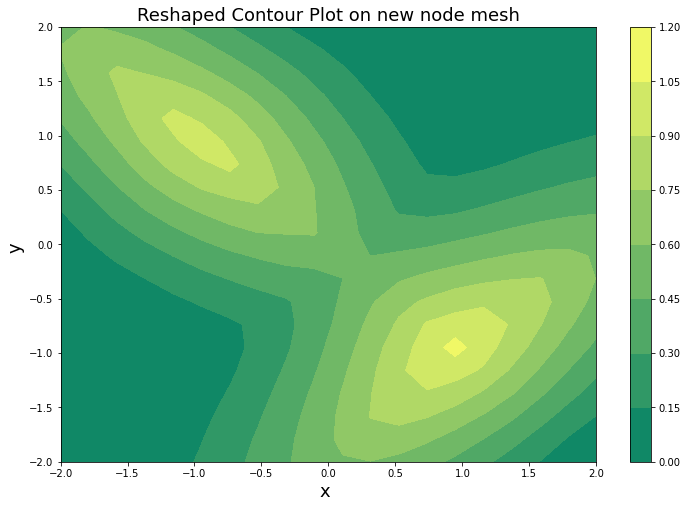

In [12]:
'''
    Stretch the mesh back out to put nodes on an evenly spaced grid, and show the value function. in this warped space. 
    Changes in the value function are now more evenly spaced. 
'''

cmap = "summer" #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)


mX,mY = p1.locationMesh()
G = two_Guassians(mX,mY, mu1, Sigma1, mu2, Sigma2)



fig,ax=plt.subplots(1,1)
fig.set_size_inches(12, 8)
cp = ax.contourf(initX,initY, G, cmap=cmap)  #original mesh to plot guassian


fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Reshaped Contour Plot on new node mesh', fontsize=18)
ax.set_xlabel('x ', fontsize=18)
ax.set_ylabel('y ', fontsize=18)


#plotmesh(initX,initY, plt)